In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Replace with the path to your time-series data CSV
file_path = "IL_T600_cleaned.csv"

# Load data (assume it's already sorted chronologically by index or a timestamp column)
df = pd.read_csv(file_path)
print("Data shape:", df.shape)
print(df.head(5))

# Suppose the dataset has a 'label' column for classification
# and other columns are features.
print("\nColumns:", df.columns.tolist())


Data shape: (20000, 20)
   label       Mean        RMS    Variance  Standard Deviation  Peak-to-Peak  \
0      0  49.588635  50.778060  119.378598           10.926051            72   
1      0  49.680272  50.838850  116.459199           10.791626            70   
2      0  49.559024  50.725808  117.010822           10.817154            74   
3      0  49.338936  50.518884  117.827100           10.854819            73   
4      0  49.855542  51.024090  117.882693           10.857380            71   

   Crest Factor  Skewness  Kurtosis   Energy      Entropy  Max  Min  \
0      1.516403 -0.765184  3.495894  6443450 -702891.2250   77    5   
1      1.514590 -0.763123  3.487779  6458887 -704360.0378   77    7   
2      1.537679 -0.753239  3.445247  6430196 -702250.8838   78    4   
3      1.524183 -0.764606  3.508723  6377842 -698437.2802   77    4   
4      1.509091 -0.765734  3.506680  6506041 -707510.5325   77    6   

   peak_magnitude  spectral_centroid  spectral_bandwidth  spectral_f

In [4]:
# Separate features & labels
X = df.drop(columns=["label"]).values  # shape: (num_samples, num_features)
y = df["label"].values                 # shape: (num_samples,)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("\nFirst 5 rows of scaled features:\n", X_scaled[:5])


Features shape: (20000, 19)
Labels shape: (20000,)

First 5 rows of scaled features:
 [[0.51001499 0.51626844 0.81756003 0.82062881 0.45454545 0.38759349
  0.42450299 0.64613992 0.50915069 0.48986921 0.4        0.57142857
  0.43670978 0.61852832 0.50007212 0.67468562 0.61111111 0.6844469
  0.04713234]
 [0.54121815 0.53728998 0.51641461 0.52161689 0.27272727 0.37001935
  0.45055526 0.61163015 0.53020432 0.46143226 0.4        0.85714286
  0.52172649 0.71472973 0.54428086 0.52301933 0.61111111 0.52668587
  0.06166142]
 [0.49993187 0.49819954 0.57331632 0.5784002  0.63636364 0.59380424
  0.57551126 0.43075228 0.49107434 0.50226654 0.6        0.42857143
  0.46926319 0.78727974 0.74891365 0.6060854  0.61111111 0.74470102
  0.05328242]
 [0.42498978 0.4266437  0.65751796 0.66218161 0.54545455 0.46299493
  0.43180166 0.7006988  0.41967178 0.57609981 0.4        0.42857143
  0.47754687 0.76709286 0.42440992 0.62508335 0.61111111 0.63115068
  0.04478828]
 [0.60089931 0.60134745 0.66325265 0.667877

In [5]:
timesteps = 10  # or however many steps of history you need

def create_sequences(data, labels, seq_len):
    seqs, labs = [], []
    for i in range(len(data) - seq_len + 1):
        seqs.append(data[i : i + seq_len]) 
        labs.append(labels[i + seq_len - 1])
    return np.array(seqs), np.array(labs)

X_seq, y_seq = create_sequences(X_scaled, y, seq_len=timesteps)

print("X_seq shape:", X_seq.shape)  # e.g., (N, 5, num_features)
print("y_seq shape:", y_seq.shape)  # e.g., (N,)


X_seq shape: (19991, 10, 19)
y_seq shape: (19991,)


In [6]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        """
        input_dim:  number of features per timestep
        hidden_dim: size of LSTM hidden layer
        output_dim: number of classes (2 for binary classification)
        """
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: (batch, timesteps, input_dim)
        lstm_out, _ = self.lstm(x)      # shape: (batch, timesteps, hidden_dim)
        last_step   = lstm_out[:, -1, :] # final timestep
        logits      = self.fc(last_step) # (batch, output_dim)
        return logits  # raw logits (for CrossEntropyLoss)


In [7]:
# Number of folds for time-based CV
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# We'll store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

epochs = 5       # training epochs per fold
hidden_dim = 32  # size of LSTM hidden layer
batch_size = 64
lr = 0.001       # learning rate

fold_idx = 1

for train_idx, test_idx in tscv.split(X_seq):
    print(f"\n=== Fold {fold_idx}/{n_splits} ===")
    fold_idx += 1
    
    # Split data for this fold
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]
    
    # Convert to PyTorch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
    y_test_t  = torch.tensor(y_test,  dtype=torch.long).to(device)
    
    # Create DataLoaders (no shuffle for time-series)
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),
                              batch_size=batch_size, shuffle=False)
    
    # Initialize a fresh model for each fold
    input_dim = X_train.shape[2]  # number of features
    model = SimpleLSTM(input_dim, hidden_dim, output_dim=2).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train for 'epochs' epochs
    for ep in range(1, epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, pred = torch.max(logits, 1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()
        # Optionally print epoch stats:
        # epoch_loss = running_loss / len(train_loader)
        # train_acc = 100.0 * correct / total
        # print(f"Epoch {ep}/{epochs} | Loss={epoch_loss:.4f}, Acc={train_acc:.2f}%")

    # Evaluate on test fold
    model.eval()
    y_true_fold, y_pred_fold = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            logits = model(Xb)
            _, predicted = torch.max(logits, 1)
            y_true_fold.extend(yb.cpu().numpy())
            y_pred_fold.extend(predicted.cpu().numpy())
    
    # Compute metrics
    acc  = accuracy_score(y_true_fold, y_pred_fold)*100
    prec = precision_score(y_true_fold, y_pred_fold, zero_division=0)*100
    rec  = recall_score(y_true_fold, y_pred_fold, zero_division=0)*100
    f1   = f1_score(y_true_fold, y_pred_fold, zero_division=0)*100
    
    print(f"Fold Accuracy:   {acc:.2f}%")
    print(f"Fold Precision:  {prec:.2f}%")
    print(f"Fold Recall:     {rec:.2f}%")
    print(f"Fold F1-score:   {f1:.2f}%")
    
    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

# Summarize across folds
mean_acc  = np.mean(fold_accuracies)
mean_prec = np.mean(fold_precisions)
mean_rec  = np.mean(fold_recalls)
mean_f1   = np.mean(fold_f1s)

std_acc   = np.std(fold_accuracies)
std_prec  = np.std(fold_precisions)
std_rec   = np.std(fold_recalls)
std_f1    = np.std(fold_f1s)

print("\n=== Final TimeSeriesSplit Cross-Validation Results ===")
print(f"Accuracy:   {mean_acc:.2f}% (+/- {std_acc:.2f})")
print(f"Precision:  {mean_prec:.2f}% (+/- {std_prec:.2f})")
print(f"Recall:     {mean_rec:.2f}% (+/- {std_rec:.2f})")
print(f"F1-score:   {mean_f1:.2f}% (+/- {std_f1:.2f})")



=== Fold 1/3 ===
Fold Accuracy:   99.88%
Fold Precision:  0.00%
Fold Recall:     0.00%
Fold F1-score:   0.00%

=== Fold 2/3 ===
Fold Accuracy:   0.00%
Fold Precision:  0.00%
Fold Recall:     0.00%
Fold F1-score:   0.00%

=== Fold 3/3 ===
Fold Accuracy:   0.00%
Fold Precision:  0.00%
Fold Recall:     0.00%
Fold F1-score:   0.00%

=== Final TimeSeriesSplit Cross-Validation Results ===
Accuracy:   33.29% (+/- 47.08)
Precision:  0.00% (+/- 0.00)
Recall:     0.00% (+/- 0.00)
F1-score:   0.00% (+/- 0.00)


NaN counts before fixing:
 label                 0
Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy      0
spectral_contrast     1
dtype: int64

NaN counts after fixing:
 label                 0
Mean                  0
RMS                   0
Variance              0
Standard Deviation    0
Peak-to-Peak          0
Crest Factor          0
Skewness              0
Kurtosis              0
Energy                0
Entropy               0
Max                   0
Min                   0
peak_magnitude        0
spectral_centroid     0
spectral_bandwidth    0
spectral_flatness     0
spectral_rolloff      0
spectral_entropy     

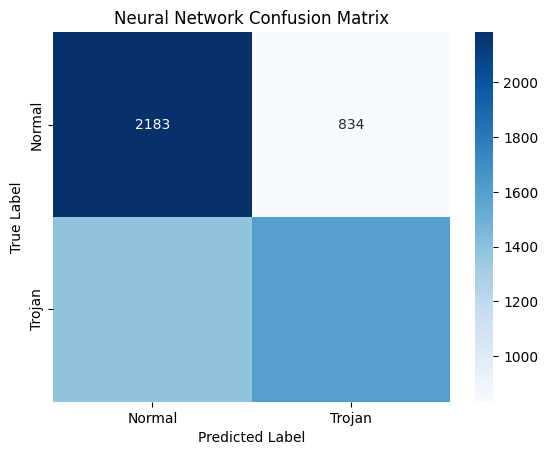

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Load and Preprocess Data
df = pd.read_csv("IL_T600_cleaned.csv")
print("NaN counts before fixing:\n", df.isnull().sum())

# Fill missing values
df['spectral_contrast'].fillna(df['spectral_contrast'].mean(), inplace=True)
print("\nNaN counts after fixing:\n", df.isnull().sum())

# Split into normal and anomaly
df_normal = df[df['label'] == 0].copy()
df_anomaly = df[df['label'] == 1].copy()

# Feature extraction
def extract_features_labels(df_in):
    X = df_in.drop(columns=['label']).values
    y = df_in['label'].values
    return X, y

X, y = extract_features_labels(df)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, rf_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, rf_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, rf_pred) * 100:.2f}%")

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.001, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("\nGradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, gb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, gb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, gb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, gb_pred) * 100:.2f}%")

# 3. Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, nb_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, nb_pred) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, nb_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, nb_pred) * 100:.2f}%")

# 4. Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

input_size = X_train.shape[1]
model = NeuralNet(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
patience = 10
counter = 0

# Training the neural network
for epoch in range(200):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_acc = accuracy_score(y_train, val_pred.numpy())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print("Early stopping activated.")
            break

# Testing the neural network
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_pred = torch.max(test_outputs, 1)

print("\nNeural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"Recall: {recall_score(y_test, test_pred.numpy()) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, test_pred.numpy()) * 100:.2f}%")

# Confusion Matrix for Neural Network
cm = confusion_matrix(y_test, test_pred.numpy())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Trojan"], yticklabels=["Normal", "Trojan"])
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
